In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.datasets import mnist
import argparse

In [ ]:
class KMeans():
    def __init__(
        self,
        x_train,
        y_train,
        num_clusters=3,
        max_iter=100,
        tol=1e-4,
        seed: str = None,
    ):
        """
        Initialize KMeans object.
        Arguments:
            dataset: numpy array of shape (n_samples, n_features)
            k: number of clusters
            max_iter: maximum number of iterations
            tol: tolerance for convergence
            seed: initial cluster centroids choice ['random','cluster']
        """
        self.dataset = x_train
        self.targets = y_train

        self.k = num_clusters
        self.max_iter = max_iter
        self.tol = tol

        self.num_features = x_train.shape[1]
        self.num_samples = x_train.shape[0]
        self.losses = []

        if seed == "random":
            self.centroids = np.random.uniform(
                size=(self.k, self.num_features))
        elif seed == "cluster":
            if (self.k > self.num_samples):  # hack for large k
                self.centroids = np.copy(self.dataset[np.random.choice(
                    self.num_samples, self.k, replace=True)])
            else:
                self.centroids = np.copy(self.dataset[np.random.choice(
                    self.num_samples, self.k, replace=False)])
        else:
            raise ValueError("seed must be in ['random', 'cluster']")
        # store old centroids for convergence check
        self.old_centroids = np.copy(self.centroids)
        # store cluster assignment indexes
        self.cluster_labels = np.zeros(self.num_samples, dtype=int)

    def converged(self):
        """
        Checks if the kmeans algorithm has converged.
        The algorithm has converged if the centroids have not changed by a h.p tolerance
        Returns:
            bool: True if converged, False otherwise
        """
        return np.all(np.linalg.norm(self.centroids - self.old_centroids, ord=2, axis=1) < self.tol)

    def assign_clusters(self):
        """
        Assigns each sample to a cluster.
        """
        for i in range(self.num_samples):
            self.cluster_labels[i] = np.argmin(
                np.linalg.norm(self.dataset[i]-self.centroids, ord=2, axis=1))

    def get_centroid_labels(self):
        """
        Computes the label class for each centroid by finding the maxmimum freq of a label in a cluster.
        Returns:
            numpy array of shape (k,)
        """
        centroid_labels = np.zeros(self.k)
        for i in range(self.k):
            count = np.bincount(self.targets[self.cluster_labels == i])
            if len(count) > 0:
                centroid_labels[i] = np.argmax(count)
        return centroid_labels

    def fit(self, verbose=False, plot=False):
        """
        Runs the KMeans algorithm.
        Args:
            verbose (bool, optional): Parameter to print every iteration result. Defaults to False.
            plot (bool, optional): Parameter to plot J_clust vs Iterations. Defaults to False.
        """
        for i in range(self.max_iter):
            self.assign_clusters()
            self.update_centroids()
            loss = self.calc_loss()
            self.losses.append(loss)
            if verbose:
                print(f"Iteration {i+1} Loss: {loss}")
                print("---------------------------")
            if self.converged():
                print(f"{loss}")
                break
            self.old_centroids = np.copy(self.centroids)
        if plot:
            self.plot_loss()

    def plot_loss(self):
        """
        Plots the loss vs iterations.
        """
        plt.plot(self.losses)
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.show()

    def calc_loss(self):
        """
        Calculates the J_clust loss value
        Returns:
            float: J_clust loss value
        """
        loss = np.mean(np.square(np.linalg.norm(
            self.dataset - self.centroids[self.cluster_labels], ord=2, axis=1)), axis=0)
        return loss

    def update_centroids(self):
        """
        Updates the centroids by finding the mean of each cluster.
        Note:
            If a cluster is empty, the centroid is set to a random point in the dataset.
        """
        for i in range(self.k):
            alloted = self.dataset[self.cluster_labels == i]
            if len(alloted) > 0:
                self.centroids[i] = np.mean(alloted, axis=0)
            else:
                self.centroids[i] = np.zeros(self.num_features)

    def predict(self, x):
        """
        Predicts the label for a given sample. by finding out in which cluster it belongs and the cluster label
        Args:
            x (numpy array): samples to predict label for
        Returns:
            numpy array of shape (n_samples,)
        """
        labels = np.zeros(x.shape[0], dtype=int)
        for i in range(x.shape[0]):
            labels[i] = np.argmin(
                np.linalg.norm(x[i]-self.centroids, ord=2, axis=1))
        return self.get_centroid_labels()[labels]

In [ ]:
def seed_everything(seed):
    """
    Util function to seed numpy and random
    Args:
        seed (int)
    """
    random.seed(seed)
    np.random.seed(seed)

In [ ]:
def load_data():
    """
    Loads the mnist dataset and returns train and test dataset
    """
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # normalize training and test data
    x_train = x_train / 255
    x_test = x_test / 255
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)

    digits = []
    targets = []
    for i in range(10):
        images = x_train[y_train == i]
        digits.append(images[np.random.choice(
            len(images), 100, replace=False)])
        targets.append(np.full((100,), i))

    x_train = np.vstack(digits)
    y_train = np.hstack(targets)

    # shuffle the data
    permutation = np.random.permutation(x_train.shape[0])
    x_train = x_train[permutation]
    y_train = y_train[permutation]

    test_indices = np.random.choice(x_test.shape[0], 50)
    x_test = x_test[test_indices]
    y_test = y_test[test_indices]
    return (x_train, y_train), (x_test, y_test)

In [ ]:
def plot_centroids(kmeans, centroids):
    """
    Plots the centroids of the KMeans algorithm.
    Args:
        kmeans (KMeans): KMeans object
        centroids (numpy array): centroids of the KMeans object
    """
    centroid_images = np.copy(centroids.reshape(kmeans.k, 28, 28))
    centroid_images = centroid_images * 255

    centroid_labels = kmeans.get_centroid_labels()

    fig = plt.figure(figsize=(20, 20))
    nrows = 5
    ncols = kmeans.k // nrows + kmeans.k % nrows
    for i in range(kmeans.k):
        fig.add_subplot(nrows, ncols, i+1)
        plt.imshow(centroid_images[i], cmap="gray")
        plt.title(f"Label: {centroid_labels[i]}", fontsize=15)
        plt.axis("off")
    plt.show()

In [ ]:
def main(num_clusters, max_iter, seed,tol,verbose):
    """
    Utility function to run the KMeans algorithm and plot the centroids.
    """
    # load the mnist data
    (x_train, y_train), (x_test, y_test) = load_data()
    # create a kmeans instance
    kmeans = KMeans(x_train, y_train,
                    num_clusters= num_clusters,
                    max_iter=max_iter,
                    tol=tol,
                    seed=seed)

    kmeans.fit(verbose=verbose, plot=True)  # train the model
    # predict the labels from input labels and centroids
    predictions = kmeans.predict(x_test)
    print(f"Accuracy: {np.mean(predictions == y_test)}")  # print the accuracy
    plot_centroids(kmeans, kmeans.centroids)  # plot the centroids

In [ ]:
seed_everything(72)

In [ ]:
main(num_clusters=20, max_iter=1000, seed='cluster',tol=1e-6,verbose=False)

In [ ]:
main(num_clusters=20, max_iter=100, seed='random',tol=1e-6,verbose=False)

In [ ]:
def plot_jclust(max_iter, seed,tol,verbose):
    k = np.arange(start=5, stop=21, step=1, dtype=int)
    (x_train, y_train), (x_test, y_test) = load_data()
    # create a kmeans instance
    jclust = []
    for num_cluster in k:
        kmeans = KMeans(x_train, y_train,
                        num_clusters=num_cluster,
                        max_iter=max_iter,
                        tol=tol,
                        seed=seed)
        kmeans.fit(verbose=verbose)  # train the model
        jclust.append(kmeans.calc_loss())

    plt.plot(k, jclust)
    plt.xlabel("Number of Clusters")
    plt.ylabel("J-Clustering Loss")
    plt.show()

In [ ]:
plot_jclust(max_iter=1000, seed='cluster',tol=1e-6,verbose=False)

In [ ]:
plot_jclust(max_iter=1000, seed='random',tol=1e-6,verbose=False)

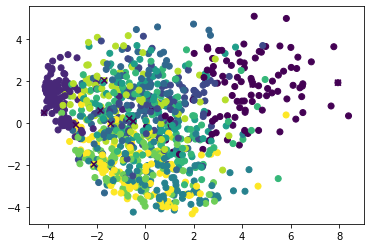

In [72]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
(x_train, y_train), (x_test, y_test) = load_data()

kmeans = KMeans(x_train, y_train,
                    num_clusters=10,
                    max_iter=1000,
                    tol=1e-7,
                    seed='cluster')

pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_cluster_pca = pca.transform(kmeans.centroids)
import matplotlib.pyplot as plt
plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=y_train)
plt.scatter(x_cluster_pca[:, 0], x_cluster_pca[:, 1], c=kmeans.get_centroid_labels(),marker='x')
plt.show()